# Matrix exponential in Python

[AMath 586, Spring Quarter 2016](http://faculty.washington.edu/rjl/classes/am586s2016/)

This notebook gives some hints on using the matrix exponential to define the solution of a linear ODE.  It also contains some other hints about linear algebra using Numpy's `ndarray` class and complex arithmetic.

See also [Numpy for Matlab Users](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html) for more tips.

For an interesting paper on the difficulties of writing general software to compute the matrix exponential accurately and efficiently, see [Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later](http://epubs.siam.org/doi/abs/10.1137/S00361445024180) by C. Moler and C. Van Loan.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Consider the ODE $u'(t) = Au$ with $u(0)=\eta$.  Then the solution can be written as $u(t) = \exp(At)\eta$.

Consider for example the case with $u(t) = [u_0(t), ~u_1(t)]$ (two components, using Python indexing notation) and
$$
A = \left[\begin{array}{rr} -2 & 0 \\ 3 & -1 \end{array}\right],
$$
as used in the notebook [Convergence_testing.ipynb](Convergence_testing.ipynb).

For this problem you can work out fairly easily by various means that the solution is
$$
u_0(t) = \eta_0 e^{-2t}, \quad u_1(t) = (\eta_1 + 3\eta_0) e^{-t} - 3\eta_0 e^{-2t},
$$
For exaple, the first equation is easy to solve directly and the second can then be solved using Duhamel's principle.  This can be coded directly as:

In [2]:
eta = array([1., -1.])  # some initial conditions
utrue_a = lambda t: array([eta[0]*exp(-2*t),  \
                        (eta[1]+3*eta[0])*exp(-t) - 3*eta[0]*exp(-2*t)])

Evaluating this at some time returns a 1-dimensional array with 2 components,

In [3]:
u = utrue_a(1.)
print "u = ", u
print "The shape of u is", u.shape
print "The type of u is ", type(u)
u  # prints u without formatting it

u =  [ 0.13533528  0.32975303]
The shape of u is (2,)
The type of u is  <type 'numpy.ndarray'>


array([ 0.13533528,  0.32975303])

Note that with Python ndarray's there is no distinction between a row vector and a column vector as there is in Matlab.

Evaluating this form at a set of $N$ times turns out to give a $2 \times N$ array:

The shape of u is  (2, 20)


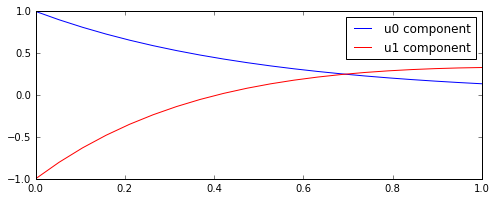

In [4]:
t = linspace(0,1,20)
u = utrue_a(t)
print "The shape of u is ", u.shape

figure(figsize=(8,3))
plot(t, u[0,:], 'b-', label='u0 component')
plot(t, u[1,:], 'r-', label='u1 component')
legend()

The solution used above can be written in matrix-vector form as
$$
u(t) = \left[\begin{array}{rr} e^{-2t}        & 0 \\
                            3(e^{-t}-e^{-2t}) & e^{-t} \end{array}\right] 
       \left[\begin{array}{r} \eta_0\\ \eta_1 \end{array}\right]
$$
which shows the matrix $\exp(At)$ and suggests that we could also code the solution as:

In [5]:
expAt_b = lambda t: array([[exp(-2*t), 0.], [3*(exp(-t)-exp(-2*t)), exp(-t)]])

utrue_b = lambda t: dot(expAt_b(t), eta)

# test this:
u = utrue_b(1.)
print "u = ", u
print "The shape of u is", u.shape

# compare with the previous solution:
udiff = utrue_a(1.) - utrue_b(1.)
print "Difference from previous solution is ", udiff

u =  [ 0.13533528  0.32975303]
The shape of u is (2,)
Difference from previous solution is  [ 0.  0.]


In this form we can **not** evaluate at an array of times and get the right result.  Look what happens if you evaluate expAt_b at an array of two times, we get a two-dimensional array of arrays.

In [6]:
t = array([0., 1.])
print "t = ", t
print "expAt_b(t) = "
print expAt_b(t)

t =  [ 0.  1.]
expAt_b(t) = 
[[array([ 1.        ,  0.13533528]) 0.0]
 [array([ 0.        ,  0.69763247]) array([ 1.        ,  0.36787944])]]


So to evaluate at several times you would have to do something like:

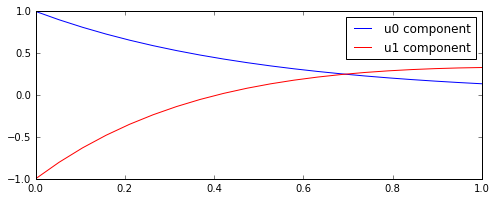

In [7]:
t = linspace(0,1,20)
u = zeros((2,len(t)))  # or empty

for j in range(len(t)):
    u[:,j] = utrue_b(t[j])

figure(figsize=(8,3))
plot(t, u[0,:], 'b-', label='u0 component')
plot(t, u[1,:], 'r-', label='u1 component')
legend()

## The expm function

An easy way to compute the matrix exponential is to use [scipy.linalg.expm](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.expm.html), which is similar to the Matlab `expm` function:

In [8]:
from scipy.linalg import expm

A = array([[-2.,0.], [3.,-1.]])  # defines 2x2 matrix

expAt_c = lambda t: expm(A*t)

print "expAt_c(1) = \n", expAt_c(1.)   # \n gives a new line

# compare to the previous version:
print "\nexpAt_b(1) = \n", expAt_b(1.)

expAt_c(1) = 
[[ 0.13533528 -0.        ]
 [ 0.69763247  0.36787944]]

expAt_b(1) = 
[[ 0.13533528  0.        ]
 [ 0.69763247  0.36787944]]


This also can't be applied to an array of arguments directly, but you could use a loop to evaluate the true solution.

## A more efficient approach

The Python `expm` function has to do some work to compute the matrix exponential and if we were evaluating at lots of points and/or had a much larger system of equations, it would be inefficient to evaluate `exp(At)` for lots of different times by applying this function over and over again to different arguments.

If the times are equally spaced, we could use the fact that $u(t+k) = \exp(Ak)u(t)$. So we really only need to compute the matrix $\exp(Ak)$ once and then apply it repeatedly, e.g.:

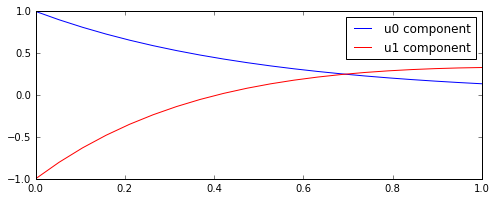

In [9]:
t = linspace(0,1,20)
k = t[1] - t[0]  # time step
u = zeros((2,len(t)))  # or empty
u[:,0] = eta  # first column = initial value at time t[0]

expAk = expm(A*k)

for j in range(len(t)-1):
    u[:,j+1] = dot(expAk, u[:,j])
    
figure(figsize=(8,3))
plot(t, u[0,:], 'b-', label='u0 component')
plot(t, u[1,:], 'r-', label='u1 component')
legend()

## Computing $\exp(At)\eta$ directly

If $A$ is a matrix that is diagonalizable, so $A=R\Lambda R^{-1}$ where $\Lambda$ is diagonal and $R$ is the matrix of linearly independent eigenvectors (so $R^{-1}$ exists), then the matrix exponential is 
$$
\exp(At) = I + At + \frac 1 2 A^2t^2 + \cdots = R\,\exp(\Lambda t)\,R^{-1}.
$$
The matrix $\exp(\Lambda t)$ is diagonal with elements $\exp(\lambda_j t)$  If we define $\bar w = R^{-1}\eta$ and $w(t) = \exp(\Lambda t)R^{-1}\eta = \exp(\Lambda t)\bar w$, we can write this as
$$
w(t) = \exp(\Lambda t)R^{-1}\eta = \left[\begin{array}{c} e^{\lambda_0 t}\bar w_0\\ e^{\lambda_1 t}\bar w_1\end{array}\right],
$$
in the case of a $2\times 2$ matrix $A$, using Python indexing.

Then the solution can be written as  $u(t) = R w(t) = R_0 w_0(t) + R_1 w_1(t)$, where $R_0$ and $R_1$ are the columns of $R$ (i.e. the two eigenvectors).

In [10]:
A = array([[-2.,0.], [3.,-1.]])
lam,R = eig(A)

eta = array([1., -1.])
wbar = solve(R, eta)   # better to solve Rw = eta than to compute inverse matrix

utrue_c = lambda t: R[:,0]*exp(lam[0]*t)*wbar[0] + R[:,1]*exp(lam[1]*t)*wbar[1]

# test this:
u = utrue_c(1.)
print "u = ", u
print "The shape of u is", u.shape

# compare with the previous solution:
udiff = utrue_a(1.) - utrue_c(1.)
print "Difference from previous solution is ", udiff

u =  [ 0.13533528  0.32975303]
The shape of u is (2,)
Difference from previous solution is  [  0.00000000e+00  -5.55111512e-17]


Again, you would have to loop over t values to evaluate this at an array of times.

Alternatively, you could write a function for the true solution that checks if the input `t` is an array and if so, do the loop inside the function and return an appropriate array. But that's a bit more complicated.

## Complex eigenvalues

Some new issues can arise when working with complex numbers in Python.  A complex number like $3+4i$ where $i=\sqrt{-1}$ is denoted in Python as `3+4j`.

Note that trying to compute `sqrt(-1)` gives an error with the built-in standard `sqrt` function but that you can compute `sqrt(-1+0j)` and it will return `1j`.  

The `cmath` module may also be useful for dealing with complex numbers, e.g. `cmath.sqrt(-1)` also returns `1j`.

### Non-damped pendulum

Consider the simplest linear pendulum problem $\theta''(t) = \theta(t)$ with given initial conditions $\theta(0)=\eta_0$ and $\theta'(0)=\eta_1$.  The solution is $\theta(t) = \eta_0\cos(t) + \eta_1\sin(t)$.  If we rewrite the problem as a first order system with $u(t) = [\theta(t),~\theta'(t)]^T$, then the system is $u'(t) = Au(t)$ with 
$$
A = \left[\begin{array}{rr} 0&1\\ -1&0\end{array}\right].
$$
This matrix is skew-symmetric with pure imaginary eigenvalues $\pm i$. Python computes the normalized eigenvector matrix
$$
R = \frac 1 {\sqrt{2}} \left[\begin{array}{rr} 1&1\\ i&-i\end{array}\right].
$$
(Normalized so the 2-norm of each column is 1.)


In [11]:
A = array([[0,1.], [-1.,0]])
lam, R = eig(A)
print "eigenvalues: ",lam
print "eigenvector matrix:\n", R

eigenvalues:  [ 0.+1.j  0.-1.j]
eigenvector matrix:
[[ 0.70710678+0.j          0.70710678-0.j        ]
 [ 0.00000000+0.70710678j  0.00000000-0.70710678j]]


Of course the matrix $e^{At}$ is always real (clear from the Taylor series expansion).  If you haven't computed this by hand for this simple case you should do so to see how all the complex exponentials combine to give sines and cosines in $\theta(t)$ and $\theta'(t)$.

But if we use Python to compute the true solution using the eigendecomposition, the arithmetic will have to take place using complex numbers.  We expect the result to end up being real, which means we expect it to have the form `x+0j`.  (Note: Because of round-off error it might not be exactly real, it might end up with an imaginary part that is very small.)

In [12]:
eta = array([1., 1.])
wbar = solve(R, eta)   # better to solve Rw = eta than to compute inverse matrix
print 'wbar = ', wbar

utrue_complex = lambda t: R[:,0]*exp(lam[0]*t)*wbar[0] + R[:,1]*exp(lam[1]*t)*wbar[1]

wbar =  [ 0.70710678-0.70710678j  0.70710678+0.70710678j]


In [13]:
utrue_complex(pi)

array([-1.+0.j, -1.+0.j])

If we try to store the complex arrays in a numpy array as we did before, we get a message saying that it is discarding the imaginary parts:

In [14]:
t = linspace(0,2*pi,100)
u = zeros((2,len(t)))  # or empty

for j in range(len(t)):
    u[:,j] = utrue_complex(t[j])


-c:5: ComplexWarning: Casting complex values to real discards the imaginary part


This is because the `zeros` command created a numpy array that has data type `float64` (double precision floating numbers):

In [15]:
u.dtype

dtype('float64')

If you really want to store the solution as complex values (e.g. for a problem where you know the solution is not always real), you could initialize `u` to be an array of complex values:

In [16]:
t = linspace(0,2*pi,100)
u = zeros((2,len(t)), dtype=complex)

for j in range(len(t)):
    u[:,j] = utrue_complex(t[j])

# print the first few columns to see that they are complex:
u[:,:3]

array([[ 1.00000000+0.j,  1.06141060+0.j,  1.11854727+0.j],
       [ 1.00000000+0.j,  0.93456276+0.j,  0.86536236+0.j]])

This is great, but now you might get a warning about throwing away the imaginary parts if you try to plot the solution.

A better approach, since we know the solution is real, is to only keep the real part when defining the true solution:

(0, 10)

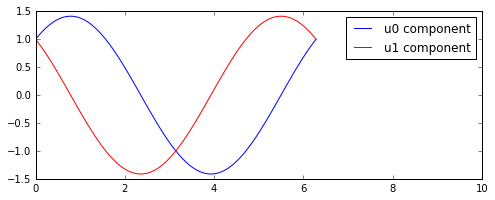

In [17]:
def utrue_real(t):
    # Write it out as a function so it's clearer
    u = R[:,0]*exp(lam[0]*t)*wbar[0] + R[:,1]*exp(lam[1]*t)*wbar[1]
    return real(u)

t = linspace(0,2*pi,100)
u = zeros((2,len(t)))

for j in range(len(t)):
    u[:,j] = utrue_real(t[j])

figure(figsize=(8,3))
plot(t, u[0,:], 'b-', label='u0 component')
plot(t, u[1,:], 'r-', label='u1 component')
legend()
xlim(0,10)